# Лекция 3. Обработка видео: трекинг объектов и фильтр Кальмана

In [1]:
from __future__ import division

First install the following software:
  
  1. [X] Install **Anaconda** 
  2. open terminal and run the following commands:
     ```bash
     
     # -- stuff, conda knows about
     conda install traits 
     conda install traitsui
     conda install wxpython 
     conda install h5py
     conda install pandas
     conda install numba
     
     # -- stuff, conda doesn't know about
     pip install swan
     pip install https://github.com/pyimreg/imreg/archive/master.zip
     pip install https://github.com/uqfoundation/dill/archive/master.zip
     pip install https://github.com/uqfoundation/pathos/archive/master.zip
     
     # -- finally, lo and behold
     
     pip install --no-deps -U https://github.com/abrazhe/image-funcut/archive/develop.zip
     ```

In [2]:
# Нам понадобится интерактивное взаимодействие с рисунками,
# поэтому используем один из интерактивных бэкендов (tk)
%pylab tk

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
sys.path.append('/usr/lib/python2.7/dist-packages')

In [4]:
from scipy import ndimage
from numba import jit

In [5]:
style.use('ggplot')
rc('image', aspect='equal')
rc('figure', figsize=(10,10))
rc('grid', c='0.5', ls='..', lw=0.5)

In [8]:
files = !ls media/*.mp4

In [9]:
files

['media/hexbug1.mp4']

In [10]:
from imfun import fseq, ui, lib

In [11]:
import cv2

In [12]:
vidcap = cv2.VideoCapture(files[-1])

In [13]:
res, frame = vidcap.read()
frame.dtype, frame.min(), frame.max()

(dtype('uint8'), 0, 200)

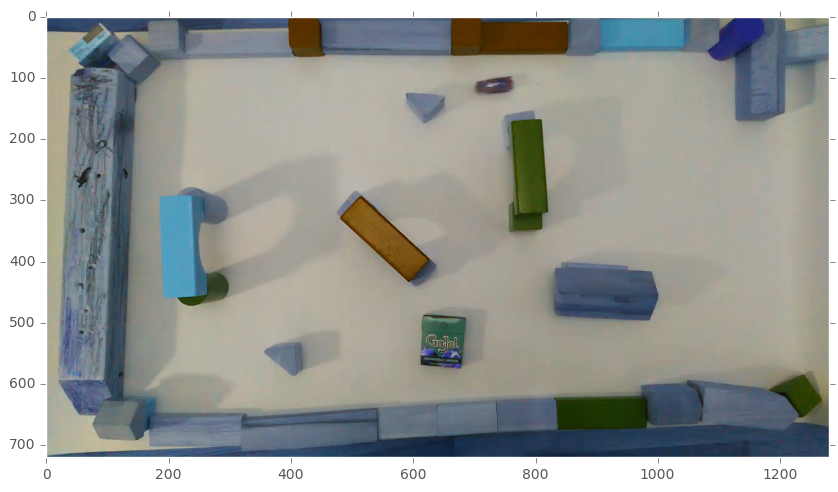

In [14]:
imshow(frame)
gcf()

Note bad colors. Revert to using the following shell command.
We will also downsample the original video.

`ffmpeg -i hexbug1.mp4 -vf scale=iw/2:-1 -qscale:v 5 images_jpg/hexbug%04d.jpg`

In [17]:
! mkdir hexbug_tmp

In [19]:

! ffmpeg -loglevel error -i media/hexbug1.mp4 -vf scale=iw/2:-1 -qscale:v 5 hexbug_tmp/hexbug%04d.jpg

In [22]:
fs = fseq.open_seq('hexbug_tmp/*.jpg',ch=None)
#fs = fseq.open_seq('hexbug-movie/*.png',ch=None)

leica:  hexbug_tmp *.jpg
leica:  hexbug_tmp/*[0-9].xml
******* hexbug_tmp/*.jpg None


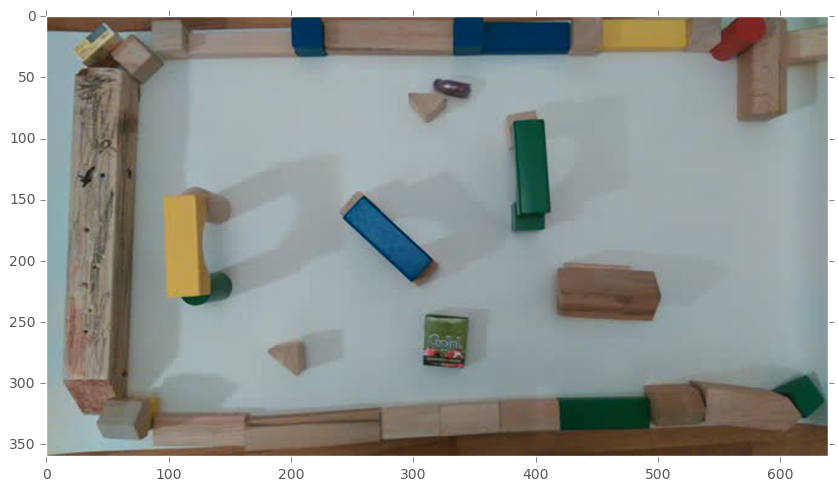

In [23]:
f = figure()
imshow(fs[10])
grid(False)
f

In [25]:
p = ui.Picker(fs); p.start(home_frame=fs[0], clim=(0.,255.))
#p.roi_coloring_model = 'allrandom'

(<matplotlib.axes._subplots.AxesSubplot at 0x7f550aa76c50>,
 <imfun.ui.Picker at 0x7f550bbd70d0>)

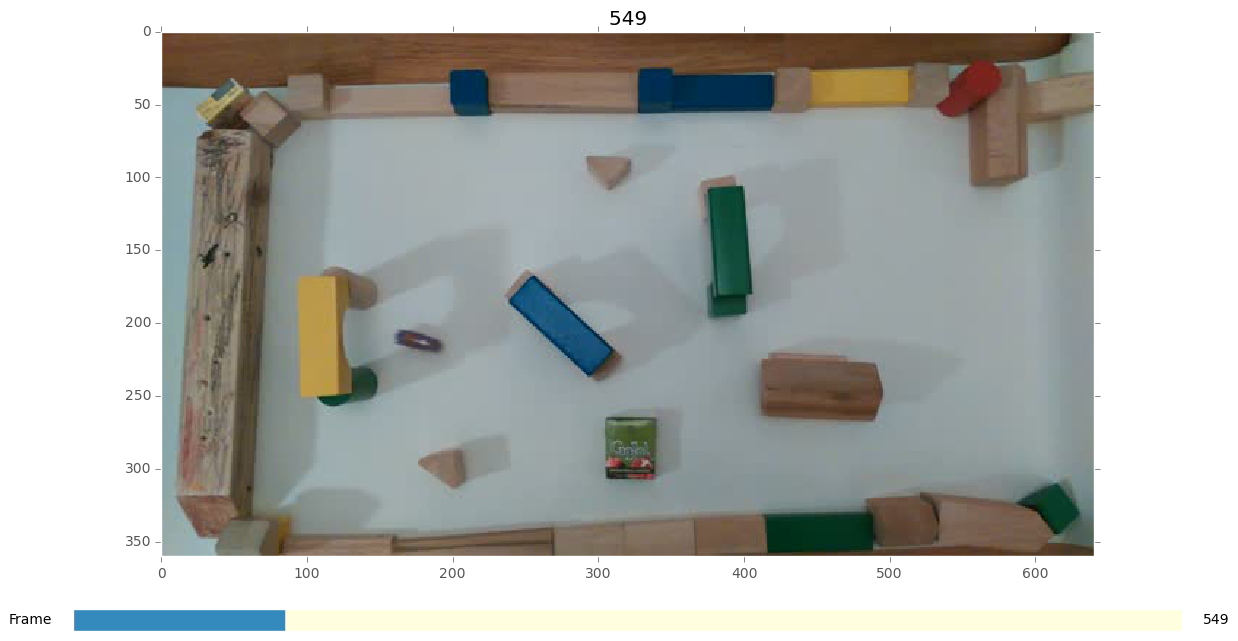

In [26]:
gcf()

In [29]:
figure(); imshow(fs[0]); grid(False); gcf()
title('First frame of the video')

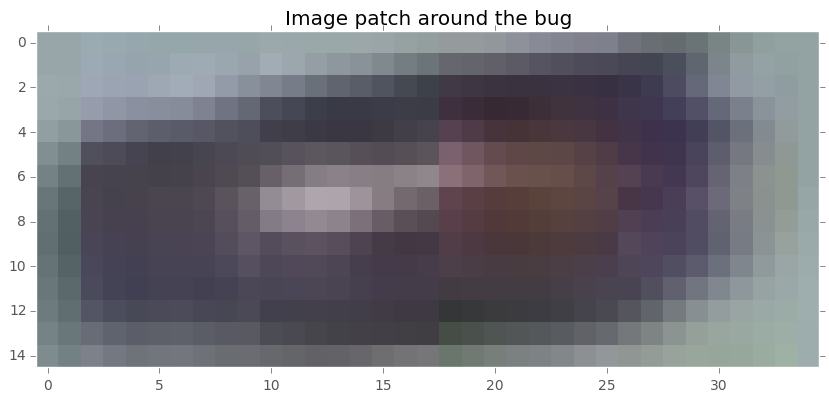

In [30]:
#patch = fs[0][39:73,350:384]
patch = fs[0][49:64,350:385]
figure(); imshow(patch, interpolation='nearest')
title('Image patch around the bug')
gcf()

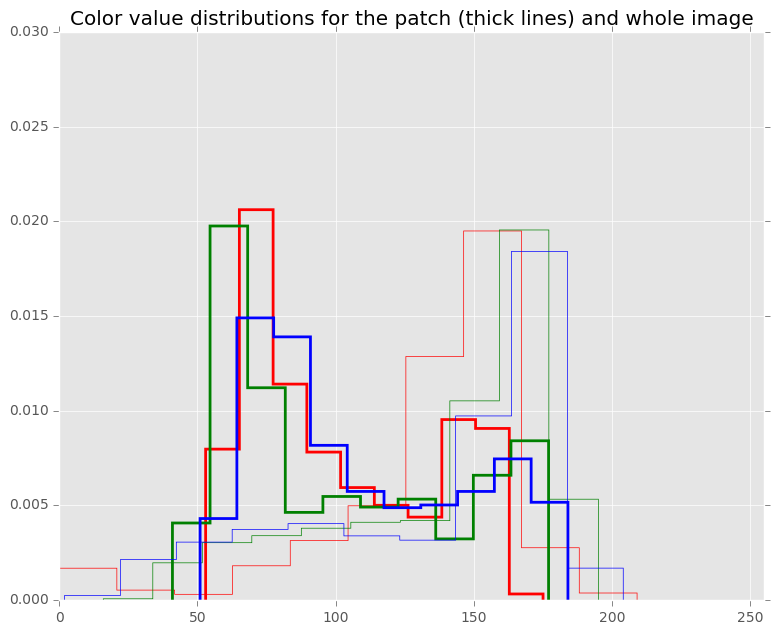

In [43]:
figure(figsize=(9,7))
for k,c in zip(range(3), 'rgb'): 
    hist(ravel(patch[...,k]), color=c, histtype='step', lw=2, normed=True)
    hist(ravel(fs[0][...,k]), color=c, histtype='step', normed=True)
xlim(0,255); ylim(0, 0.03)
grid(color='w', ls='-')
title('Color value distributions for the patch (thick lines) and whole image')    
gcf()

In [54]:
def simple_hist(im, vrange=(0,255)):
    im = ravel(im)
    levels = linspace(*vrange)[1:]
    return diff((im[:,None]<levels[None,:]).sum(0))/len(im)

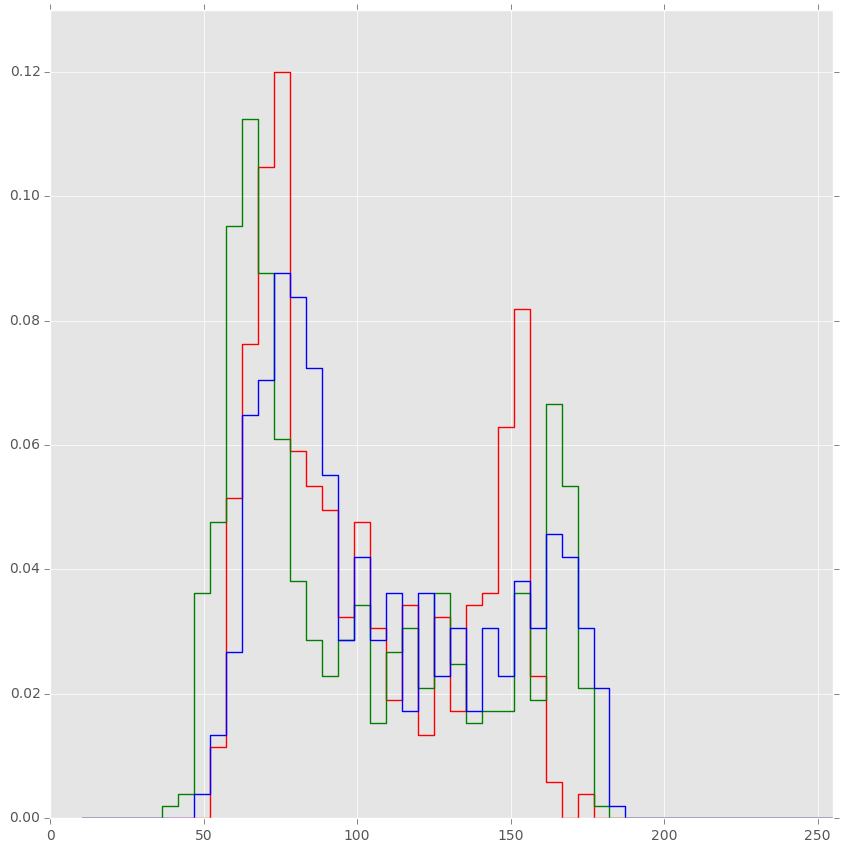

In [59]:
out = [simple_hist(patch[...,k]) for k in range(3)]

figure()
grid(color='w', ls='-')
for line,c in zip(out,'rgb') :
    #print len(line)
    plot(linspace(0,255)[2:],line,c, drawstyle='steps')
xlim(0,255); ylim(0, 0.13)
gcf()

In [60]:
@jit
def mirrorpd(i,N):
    "mirror boundary/padding conditions"
    if i < 0: return -i%N
    elif i>=N: return N-2-i%N
    else: return i

@jit            
def filt2d(u, kern,stride=1):
    uout = np.zeros_like(u)
    (Nr,Nc),(kr,kc) = u.shape,kern.shape
    indr = arange(kr)-kr//2
    indc = arange(kc)-kc//2
    for i in range(0,Nr,stride):
        for j in range(0,Nc,stride):
            uout[i,j] = 0
            for k in range(kr):
                ki = mirrorpd(i + indr[k], Nr)
                for l in range(kc):
                    li = mirrorpd(j + indc[l], Nc)
                    uout[i,j] += kern[k,l]*u[ki,li]    
    return uout

# if only Python had macros...

@jit
def sqdist2d(u, kern,stride=1):
    uout = np.zeros_like(u)
    (Nr,Nc),(kr,kc) = u.shape,kern.shape
    indr = arange(kr)-kr//2
    indc = arange(kc)-kc//2
    for i in range(0,Nr,stride):
        for j in range(0,Nc,stride):
            uout[i,j] = 0
            for k in range(kr):
                ki = mirrorpd(i + indr[k], Nr)
                for l in range(kc):
                    li = mirrorpd(j + indc[l], Nc)
                    uout[i,j] += (kern[k,l]-u[ki,li])**2  
    return uout

CPU times: user 712 ms, sys: 0 ns, total: 712 ms
Wall time: 704 ms
CPU times: user 708 ms, sys: 0 ns, total: 708 ms
Wall time: 702 ms
(56, 367)


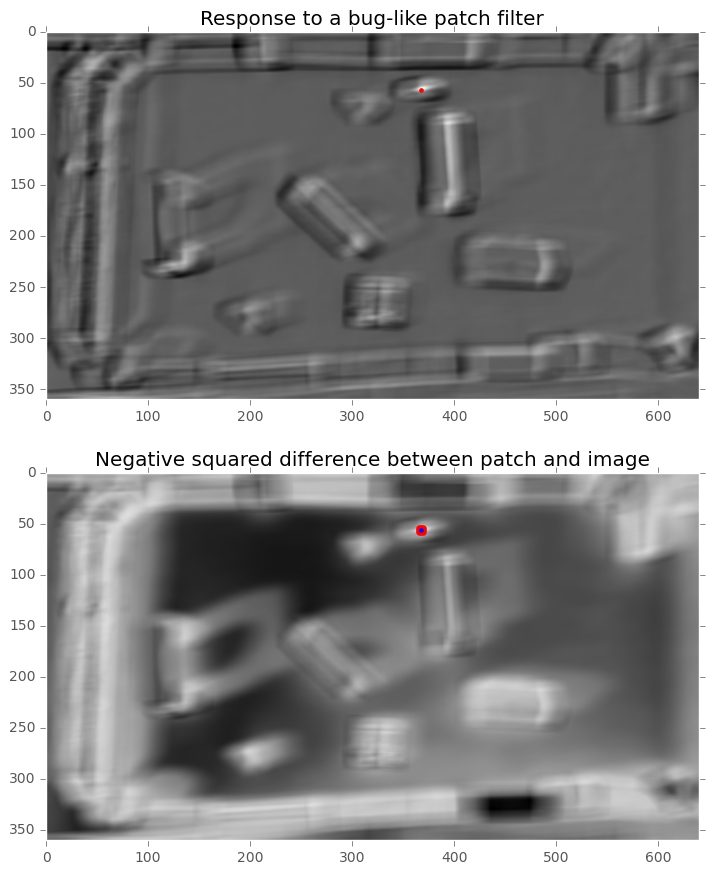

In [66]:
img = fs[0]/255.
patchx = dstack([patch[...,k]/patch[...,k].mean()-1 for k in range(3)])
%time xc = [filt2d(img[...,k], patchx[...,k], stride=1) for k in range(3)]
%time xc2 = [-sqdist2d(img[...,k], patch[...,k]/255., stride=1) for k in range(3)]
xcs = sum(xc,0)
loc1 = ndimage.maximum_position(xcs)
loc2 = ndimage.maximum_position(sum(xc2,0))
print loc1

figure(); 
subplot(2,1,1); imshow(sum(xc,0),cmap='gray'); 
a = axis(); plot(loc1[1],loc1[0], 'r.'); axis(a)
title('Response to a bug-like patch filter')

subplot(2,1,2); imshow(sum(xc2,0),cmap='gray'); 
a = axis(); 
plot(loc1[1],loc1[0], 'r.', markersize=15); 
plot(loc2[1],loc2[0], 'b.'); 
axis(a)
title('Negative squared difference between patch and image')


gcf()

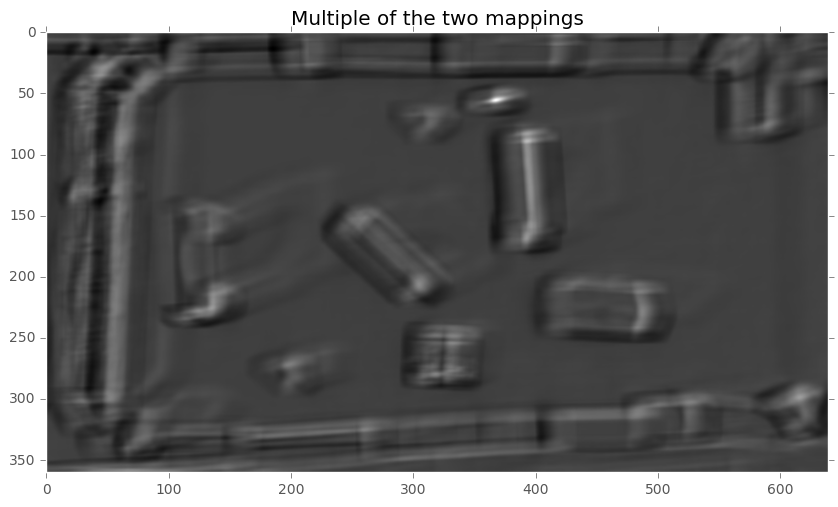

In [72]:
imshow(sum(array(xc)*lib.rescale(array(xc2)),0), cmap='gray')

title('Multiple of the two mappings')
gcf()


Можно ли использовать этот подход для поиска объекта в других кадрах? Для большей скорости, будем искать только в некоторой близости от предыдущего положения (**использование априорной информации**).

In [75]:
%%time 
fsh = fs.shape()[:2]
nhood=70
img2 = fs[5]*1.0
xc = [filt2d(img2[max(0,loc[0]-nhood):min(fsh[0],loc[0]+nhood), 
                 max(0,loc[1]-nhood):min(fsh[1],loc[1]+nhood),k], 
             patchx[...,k], stride=1) for k in range(3)]

CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 101 ms


(56, 367) (57, 51) [ 57 348]


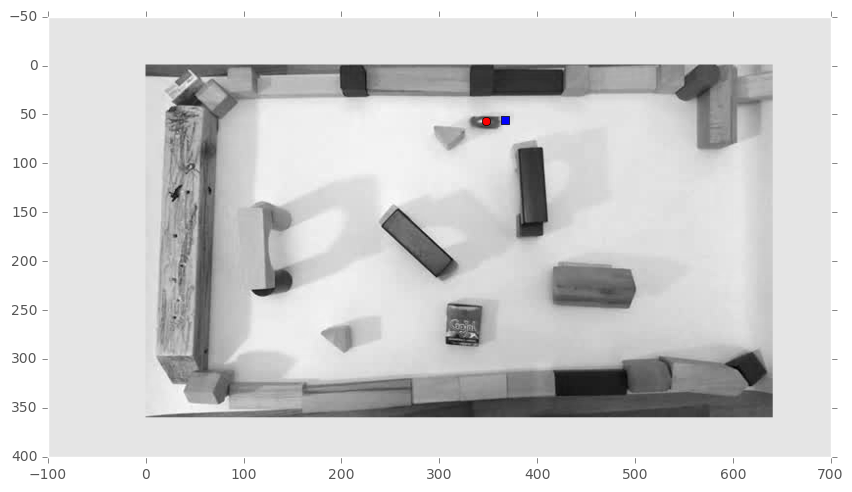

In [76]:
figure(); imshow(sum(xc,0));
figure(); 

loc2 = ndimage.maximum_position(sum(xc,0))

loc2c = array(loc2)+clip(array(loc)-nhood, 0, max(fsh))

print loc, loc2, loc2c


imshow(img2.sum(-1), cmap='gray')
plot(loc2c[1], loc2c[0], 'ro')
plot(loc[1], loc[0], 'bs')
gcf()

Однако, если объект находитя под другим углом, корреляционный метод его не находит:

CPU times: user 728 ms, sys: 0 ns, total: 728 ms
Wall time: 728 ms
(360, 640)


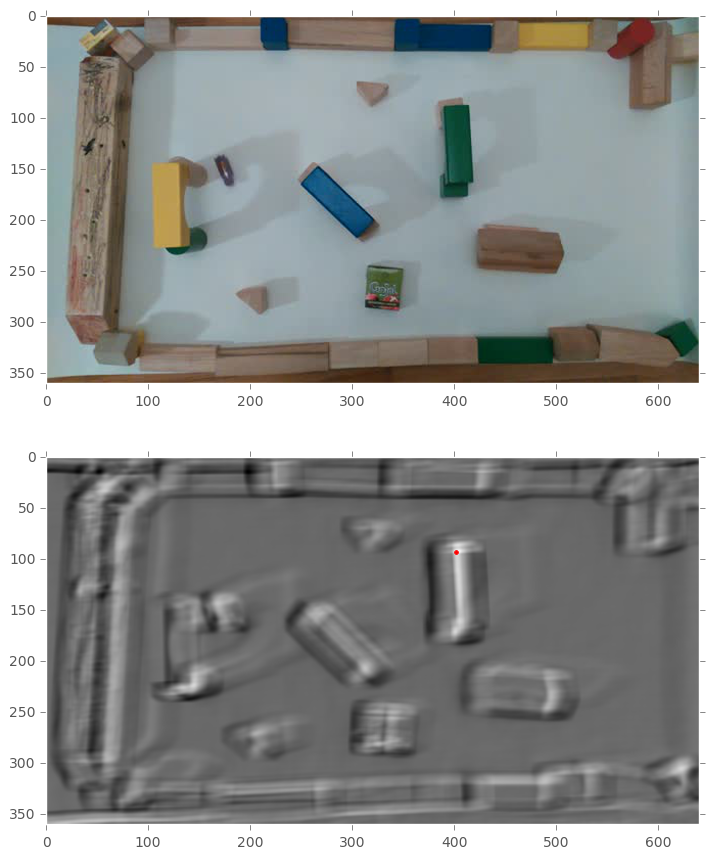

In [77]:
imgx = fs[70]/255.
patchx = dstack([patch[...,k]/patch[...,k].mean()-1 for k in range(3)])
%time xc = [filt2d(imgx[...,k], patchx[...,k], stride=1) for k in range(3)]
xcs = sum(xc,0)
loc = ndimage.maximum_position(xcs[10:-10,10:-10])
print xc[0].shape

figure(); 
subplot(211)
imshow(imgx)

subplot(212)
imshow(sum(xc,0),cmap='gray'); 
a = axis(); plot(loc[1]+10,loc[0]+10, 'r.'); axis(a)
gcf()

Поэтому попробуем использовать версии темплейта с возможными поворотами:

In [78]:
angles = [i*45 for i in range(1, 8)]

In [79]:
patches = [patch/255.] + [ndimage.rotate(patch, a,)/255. for a in angles]
#patches = [patch] + [ndimage.rotate(patch, a, reshape=False, mode='nearest') for a in angles]

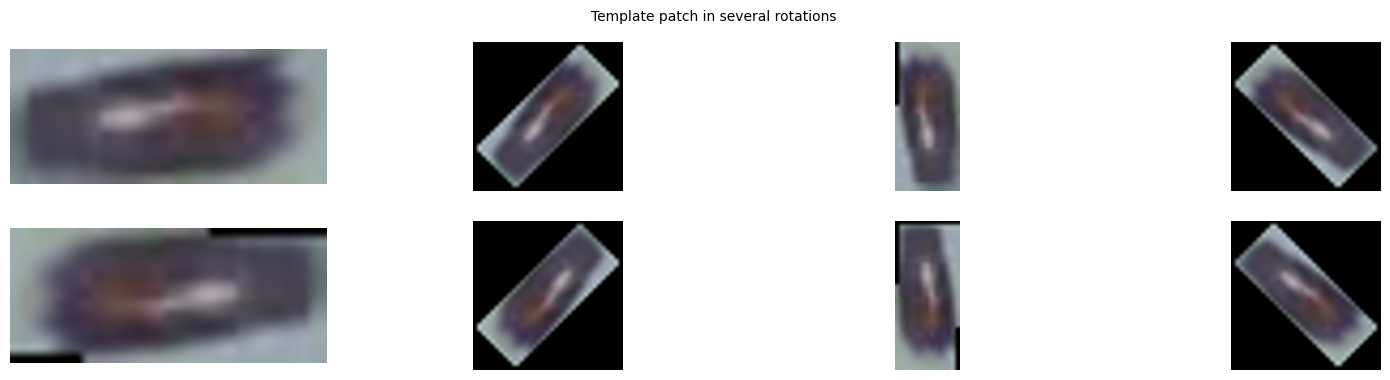

In [80]:
lib.group_maps(patches, single_colorbar=False);
suptitle('Template patch in several rotations')
gcf()

In [84]:
def norm_patch(inp):
    out = dstack([inp[...,k]/inp[...,k].mean()-1 for k in range(3)])
    #out = dstack([p[...,k]/norm(p[...,k]) for k in range(3)])
    return out

npatches = map(norm_patch, patches)
map(shape, npatches)

[(15, 35, 3),
 (35, 35, 3),
 (35, 15, 3),
 (35, 35, 3),
 (15, 35, 3),
 (35, 35, 3),
 (35, 15, 3),
 (35, 35, 3)]

In [85]:
def match_template(im, t, stride=1):
    corr = [-sqdist2d(im[...,k], t[...,k], stride=stride) for k in range(3)]
    return np.sum(corr, 0)

CPU times: user 10.3 s, sys: 0 ns, total: 10.3 s
Wall time: 10.3 s


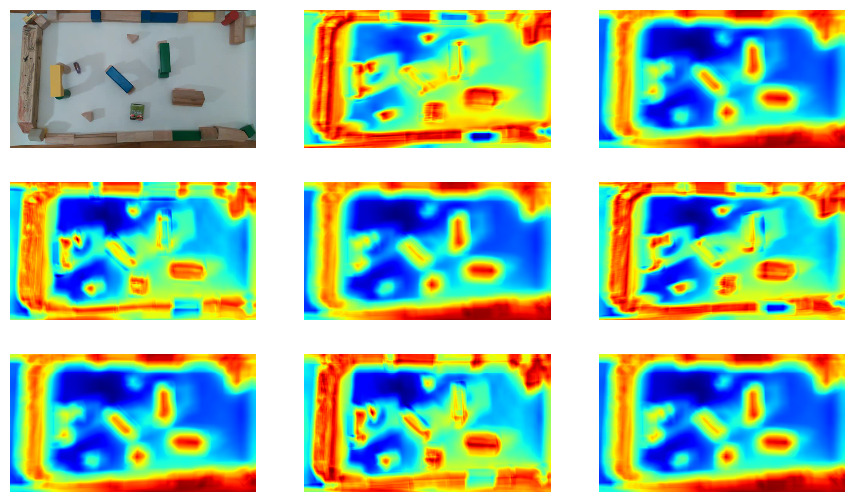

In [86]:
%time matches = [match_template(imgx, m, 1) for m in patches]
matches = [m for m in matches]
lib.group_maps([imgx] + matches, samerange=False)
gcf()

(141, 165)


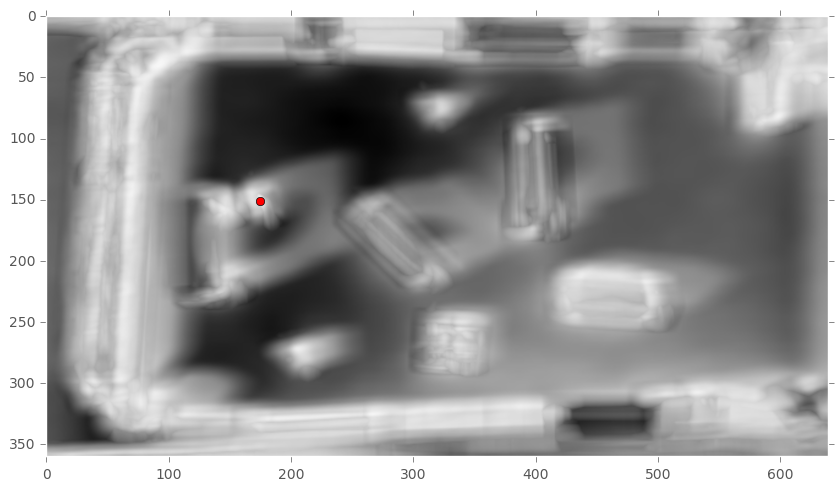

In [89]:
out = amax(matches,0)
locx = ndimage.maximum_position(out[10:-10,10:-10])
print locx
figure()
imshow(out, cmap='gray');
ax = axis(); plot(locx[1]+10, locx[0]+10, 'ro'); axis(ax)
gcf()

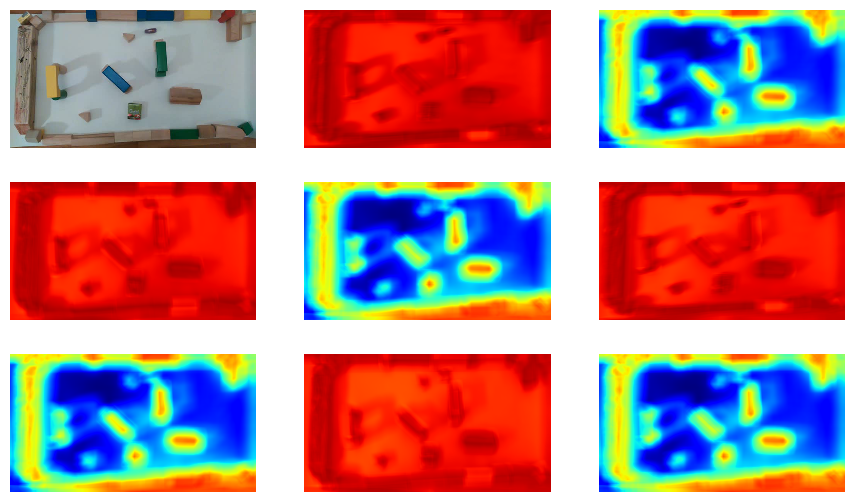

In [90]:
matches =  [match_template(fs[0]/255., p) for p in patches]
lib.group_maps([fs[0]/255.] + matches, single_colorbar=False)
gcf()

(46, 357)


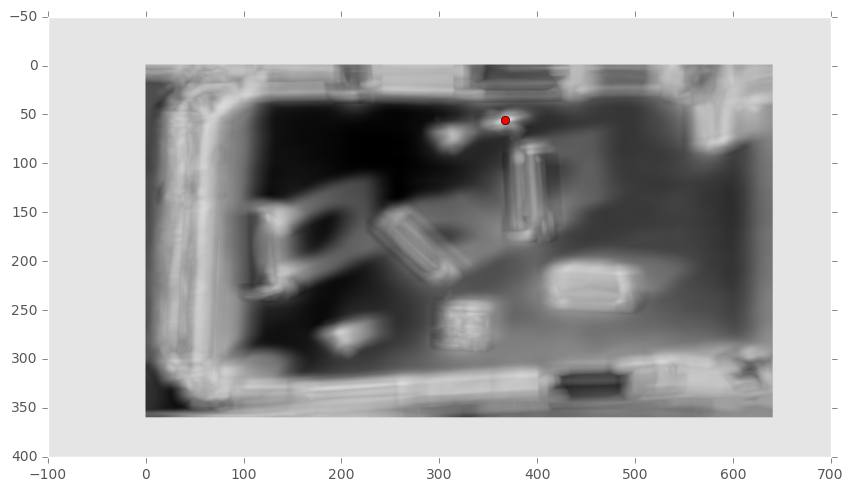

In [91]:
out = amax(matches,0)
locx = ndimage.maximum_position(out[10:-10,10:-10])
print locx
figure()
imshow(out, cmap='gray');
plot(locx[1]+10, locx[0]+10, 'ro')
gcf()

Скомбинируем все вместе в трекинг:

In [92]:
def track_object(frames, init_loc, template):
    angles = [i*45 for i in range(1, 16)]
    templates = [template/255.] + [ndimage.rotate(patch, a)/255. for a in angles]
    #templates = map(norm_patch, templates)
    nhood = int(ceil(amax(template.shape)*3))
    loc = array(init_loc)
    track = []
    for img in frames:
        fsh = img.shape[:2]
        lowr = clip(loc-nhood-1,0, amax(fsh))
        highr = min(fsh[0],loc[0]+nhood),min(fsh[1],loc[1]+nhood)
        search_space = img[lowr[0]:highr[0],lowr[1]:highr[1],...]
        matches = [match_template(search_space/255., tx,stride=1) for tx in templates]
        best = amax(matches, axis=0)
        loc2 = ndimage.maximum_position(best)
        loc2 = array(loc2)+clip(loc-nhood, 0, max(fsh))
        track.append(loc2)
        loc = loc2
    return squeeze(track)

In [93]:
%time out = track_object(fs[:20], (50, 350), patch)

CPU times: user 5min 2s, sys: 0 ns, total: 5min 2s
Wall time: 5min 1s


In [94]:
p = ui.Picker(fs); p.start(home_frame=fs[0], clim=(0,255.))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f54d792e850>,
 <imfun.ui.Picker at 0x7f54dc222450>)

In [95]:
ax = gcf().axes[0]

xc = ax.plot(out[0,1],out[0,0], 'rs',ms=15)[0]

#setp(xc,markersize=20)

def marker_hook(n):
    if 0 <= n < len(out):
        xc.set_data(out[n,::-1])
    else:
        xc.set_data([0,0])

p.frame_hooks = [marker_hook]

В общем, метод получился не очень удобный в использовании. Но какой еще априорной информацией мы можем воспользоваться?

-----

## Детекция, основанная на подвижности объекта

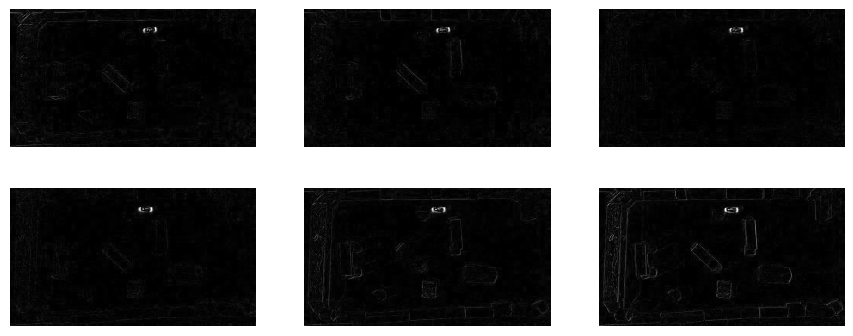

In [96]:
#fx = map(fresp, fs[:10])
fs.fns = [lambda f: ndimage.gaussian_filter(f, [1,1,0])/255.]
fxd = [abs(fs[i+1]-fs[i]).sum(-1) for i in range(6)]
lib.group_maps(fxd, ncols=3, samerange=False, imkw=dict( cmap='gray'))
gcf()

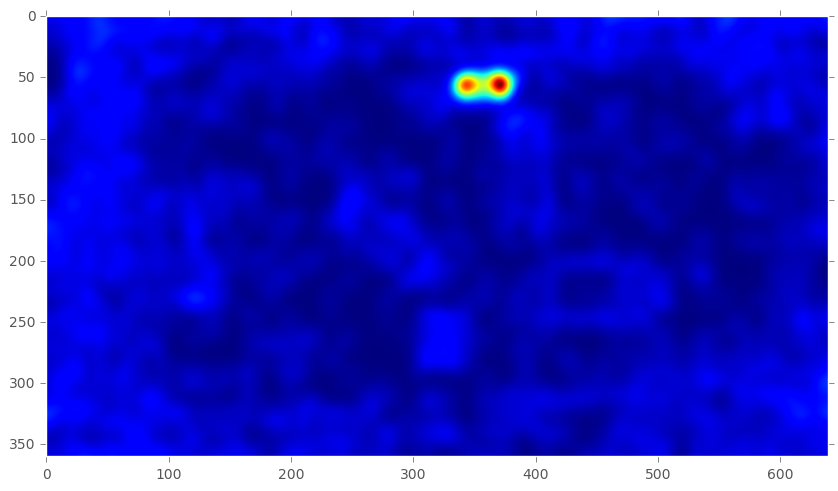

In [97]:
figure()
x = ndimage.gaussian_filter(fxd[2], 6)
imshow(x)
gcf()

In [100]:
#xdiff = lambda i: abs(fs[i+1]-2*fs[i]+fs[i-1]).sum(-1)
xdiff = lambda i: abs(fs[i+1]-fs[i]).sum(-1)
xsmooth = lambda f: ndimage.gaussian_filter(f, 3)

In [101]:
fs.fns = [lambda f: ndimage.gaussian_filter(f, [1,1,0])/255.]

fsdiff = lambda : (xdiff(i) for i in xrange(1,len(fs)-1))
fsdiff_smooth = lambda: (xsmooth(f) for f in fsdiff())

fs2 = fseq.open_seq(array(lib.take(500, fsdiff())))
p2 = ui.Picker(fs2); p2.start()

%time track = array([ndimage.maximum_position(f) for f in fsdiff()])


CPU times: user 1min 38s, sys: 404 ms, total: 1min 39s
Wall time: 1min 39s


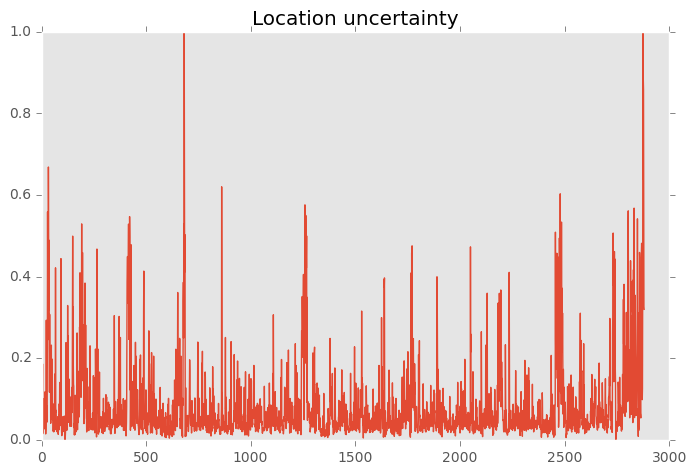

In [103]:
sigma_m = lib.rescale(array([(f.std()/f.max())**2 for f in fsdiff()]))
figure(figsize=(8,8/1.6)); plot(sigma_m); 
title('Location uncertainty');
gcf()

In [105]:
fs.fns = []
p = ui.Picker(fs); p.start(home_frame=fs[0], clim=(0.,255.))

def marker_hook(ax, trackx, color='y'):
    xh = ax.plot(trackx[0,1],trackx[0,0], 's',color=color,ms=15)[0]
    def _(n):
        if 0 <= n < len(trackx):
            xh.set_data(trackx[n,:2][::-1])
        else:
            xh.set_data([0,0])
    return _

p.frame_hooks = [marker_hook(p.ax1,array(track))]

/home/brazhe/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [106]:
def simple_kalman_filt(measurements, predictor, var_start = 1., var_m_start=1., nhist=10):
    state = []
    miter = iter(measurements)
    state = [miter.next()]
    meas_hist = np.zeros((nhist,)+state[0].shape)
    count = 0
    var_p,var_m = var_start,var_m_start
    k_acc = []
    for m in miter:
        predicted = predictor(state[-1])
        meas_hist[count%nhist] = m
        if count > nhist:
            var_m = var_m_start*var(meas_hist,axis=0).sum()
        K = var_p/(var_m + var_p)
        k_acc.append([K, var_m, var_p])
        state.append(predicted + K*(m-predicted))
        var_p = var_start*(1-K)
        count +=1
    return array(state), array(k_acc)

def predictor_damped_motion(x, damping=0.9):
    out = np.zeros_like(x)
    out[0] = x[0] + x[2]
    out[1] = x[1] + x[3]
    out[2] = x[2]*damping
    out[3] = x[3]*damping
    return out

/home/brazhe/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


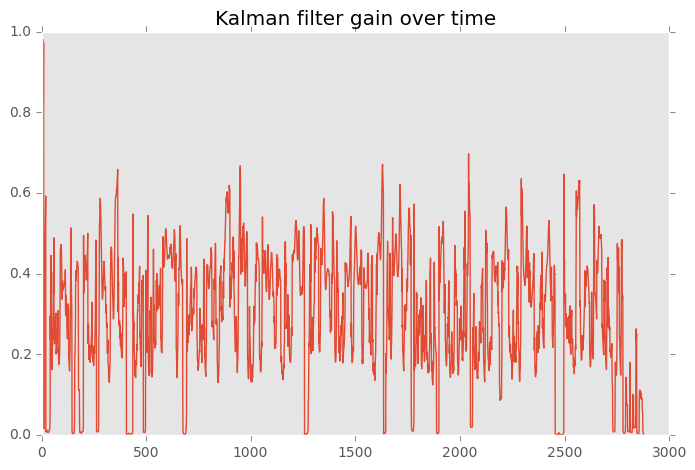

In [108]:
measures = hstack([track[1:], diff(track, axis=0)]).copy()
track_f, k_hist = simple_kalman_filt(measures, predictor_damped_motion, 100., 0.50, nhist=10)

figure(figsize=(8, 8/1.618)); plot(k_hist[:,0])
title('Kalman filter gain over time')
gcf()

In [110]:
fs.fns = []
p = ui.Picker(fs); p.start(home_frame=fs[0], clim=(0.,255.))

a = gcf().axes[0]
p.frame_hooks = [marker_hook(a,array(measures), color='y'),
                marker_hook(a, array(track_f), color='r')]

** Добавим больше шума в измерения **

In [317]:
noisy_measures = measures + 5*randn(*measures.shape)
track_fs, k_hist = simple_kalman_filt(noisy_measures, predictor_damped_motion, 100., 2., nhist=10)

In [319]:
fs.fns = []
p = ui.Picker(fs); p.start(home_frame=fs[0], clim=(0.,255.))

a = gcf().axes[0]
p.frame_hooks = [marker_hook(a,array(noisy_measures), color='y'),
                 marker_hook(a, array(track_fs), color='r')]

/home/brazhe/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
